# First Annotation

In [85]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import json

In [86]:
with open("../data/output/labeled_sample_adam.jsonl", "r", encoding='utf-8') as file:
    adas = [json.loads(line) for line in file]

with open("../data/output/labeled_sample_jan.jsonl", "r", encoding='utf-8') as file:
    janeczek = [json.loads(line) for line in file]

In [87]:
mapping = {
    "Mowa nienawiści": "Hate",
    "Neutralny": "Neutral",
    "Wzmacnianie": "Strenghtening",
    "Osłabianie": "Weakening",
    "Neutral": "Neutral",
    "Hate": "Hate",
    "Strenghtening": "Strenghtening",
    "Weakening": "Weakening",
    "Odwracanie": "Reversing",
}

In [88]:
def fix_labels_adam(data):
    for anno in data:
        merged_labels = []
        anno['label'].sort(key=lambda x: x[0]) 
        
        for label in anno['label']:
            if not merged_labels:
                merged_labels.append(label)
            else:
                last_label = merged_labels[-1]
                if last_label[2] == label[2]:
                    last_label[1] = max(last_label[1], label[1])
                else:
                    merged_labels.append(label)

        anno['label'] = merged_labels
        for label in anno['label']:
            label[2] = mapping[label[2]]

    return data

In [89]:
adas = fix_labels_adam(adas)

In [90]:
adam_labels = [annotation["label"][0][2] for annotation in adas]
janek_labels = [annotation["entities"][0]["label"] for annotation in janeczek]

In [91]:
results = {
    ("Neutral", "Neutral"): 0,
    ("Hate", "Neutral"): 0,
    ("Neutral", "Hate"): 0,
    ("Hate", "Hate"): 0,
}

for adam, janek in zip(adam_labels, janek_labels):
    results[(adam, janek)] += 1

In [92]:
results

{('Neutral', 'Neutral'): 89,
 ('Hate', 'Neutral'): 4,
 ('Neutral', 'Hate'): 1,
 ('Hate', 'Hate'): 6}

C:\Users\oliwe\AppData\Local\Temp\ipykernel_37848\749807516.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cm_plot.axes.set_xticklabels(["", "Hate", "Neutral"], rotation=45)
C:\Users\oliwe\AppData\Local\Temp\ipykernel_37848\749807516.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cm_plot.axes.set_yticklabels(["", "Hate", "Neutral"], rotation=45)


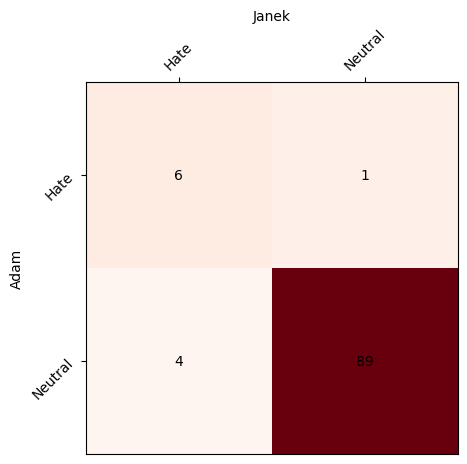

In [93]:
cm = confusion_matrix(adam_labels, janek_labels)
cm_plot = plt.matshow(cm, cmap=plt.cm.Reds)
cm_plot.axes.set_xticklabels(["", "Hate", "Neutral"], rotation=45)
cm_plot.axes.set_yticklabels(["", "Hate", "Neutral"], rotation=45)
cm_plot.axes.set_xlabel("Janek")
cm_plot.axes.set_ylabel("Adam")
cm_plot.axes.grid(False)
cm_plot.axes.xaxis.set_ticks_position('top')
cm_plot.axes.xaxis.set_label_position('top')
cm_plot.axes.text(0, 0, results["Hate", "Hate"], color="black", ha="center", va="center")
cm_plot.axes.text(1, 0, results["Neutral", "Hate"], color="black", ha="center", va="center")
cm_plot.axes.text(0, 1, results["Hate", "Neutral"], color="black", ha="center", va="center")
cm_plot.axes.text(1, 1, results["Neutral", "Neutral"], color="black", ha="center", va="center")
plt.show()

In [94]:
ppa_sentences = round((2*89/(2*89+4+1))*100, 2)
ppa_sentences

97.27

In [95]:
def filter_hate_neutral_adas(data):
    for annotation in data:
        annotations_without_hate_neutral = []
        for label in annotation["label"]:
            if label[2] != "Hate" and label[2] != "Neutral":
                annotations_without_hate_neutral.append(label)
        annotation["label"] = annotations_without_hate_neutral
    
    return data

In [96]:
def filter_hate_neutral_janek(data):
    for annotation in data:
        annotations_without_hate_neutral = []
        for entity in annotation["entities"]:
            if entity["label"] != "Hate" and entity["label"] != "Neutral":
                annotations_without_hate_neutral.append(entity)
        annotation["entities"] = annotations_without_hate_neutral
    return data

In [97]:
def ranges_match(ann1, ann2):
    match = (abs(ann1['start_offset'] - ann2[0]) <= 2 and 
            abs(ann1['end_offset'] - ann2[1]) <= 2 and 
            ann1['label'].lower() == ann2[2].lower())
    return match

In [98]:
filtered_adas = filter_hate_neutral_adas(adas)

In [99]:
filtered_labels_adam = [annotation["label"] for annotation in filtered_adas]

In [100]:
filtered_janek = filter_hate_neutral_janek(janeczek)

In [101]:
filtered_labels_janek = [annotation["entities"] for annotation in filtered_janek]

In [102]:
both_labeled = 0
first_labeled_second_not = 0
second_labeled_first_not = 0

for data1, data2 in zip(filtered_janek, filtered_adas):
    matched_1 = [False] * len(data1['entities'])
    matched_2 = [False] * len(data2['label'])

    for i, ent1 in enumerate(data1['entities']):
        for j, lab2 in enumerate(data2['label']):
            if ranges_match(ent1, lab2):
                both_labeled += 1
                matched_1[i] = True
                matched_2[j] = True

    first_labeled_second_not += sum(1 for matched in matched_1 if not matched)
    second_labeled_first_not += sum(1 for matched in matched_2 if not matched)


print(f"Both agreed: {both_labeled}")
print(f"Janek labelled, Adam did not: {first_labeled_second_not}")
print(f"Adam labelled, Janek did not: {second_labeled_first_not}")

Both agreed: 6
Janek labelled, Adam did not: 4
Adam labelled, Janek did not: 7


In [103]:
ppa_phrases = round((2*both_labeled/(2*both_labeled+first_labeled_second_not+second_labeled_first_not))*100, 2)
ppa_phrases

52.17

In [104]:
ppa_mean = round((ppa_sentences + ppa_phrases) / 2, 2)
ppa_mean

74.72

# Secound Annotation

In [107]:
import json
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


In [108]:
mapping = {
    "Mowa nienawiści": "Hate",
    "Neutralny": "Neutral",
    "Wzmacnianie": "Strenghtening",
    "Osłabianie": "Weakening",
    "Odwracanie": "Reversing",
    "Neutral": "Neutral",
    "Hate": "Hate",
    "Strenghtening": "Strenghtening",
    "Weakening": "Weakening",
}


In [109]:

def fix_labels_adam(data):
    for anno in data:
        merged_labels = []
        anno['label'].sort(key=lambda x: x[0]) 
        
        for label in anno['label']:
            if not merged_labels:
                merged_labels.append(label)
            else:
                last_label = merged_labels[-1]
                if last_label[2] == label[2]:
                    last_label[1] = max(last_label[1], label[1])
                else:
                    merged_labels.append(label)

        anno['label'] = merged_labels
        for label in anno['label']:
            label[2] = mapping[label[2]]

    return data

def map_labels_janek(data):
    for annotation in data:
        for entity in annotation["entities"]:
            entity["label"] = mapping.get(entity["label"], entity["label"])
    return data

def filter_hate_neutral_adas(data):
    for annotation in data:
        annotations_without_hate_neutral = []
        for label in annotation["label"]:
            if label[2] != "Hate" and label[2] != "Neutral":
                annotations_without_hate_neutral.append(label)
        annotation["label"] = annotations_without_hate_neutral
    return data

def filter_hate_neutral_janek(data):
    for annotation in data:
        annotations_without_hate_neutral = []
        for entity in annotation["entities"]:
            if entity["label"] != "Hate" and entity["label"] != "Neutral":
                annotations_without_hate_neutral.append(entity)
        annotation["entities"] = annotations_without_hate_neutral
    return data

def ranges_match(ann1, ann2):
    match = (abs(ann1['start_offset'] - ann2[0]) <= 2 and 
            abs(ann1['end_offset'] - ann2[1]) <= 2 and 
            ann1['label'].lower() == ann2[2].lower())
    return match

def calculate_ppa(adam_file, janek_file):
    with open(adam_file, "r", encoding='utf-8') as file:
        adas = [json.loads(line) for line in file]
    
    with open(janek_file, "r", encoding='utf-8') as file:
        janeczek = [json.loads(line) for line in file]

    adas = fix_labels_adam(adas)
    janeczek = map_labels_janek(janeczek)

    adam_labels = [annotation["label"][0][2] for annotation in adas]
    janek_labels = [annotation["entities"][0]["label"] for annotation in janeczek]

    results = {
        ("Neutral", "Neutral"): 0,
        ("Hate", "Neutral"): 0,
        ("Neutral", "Hate"): 0,
        ("Hate", "Hate"): 0,
    }

    for adam, janek in zip(adam_labels, janek_labels):
        if (adam, janek) in results:
            results[(adam, janek)] += 1
        else:
            print(f"Nieznana para etykiet: ({adam}, {janek})")

    cm = confusion_matrix(adam_labels, janek_labels, labels=["Hate", "Neutral"])
    print(f"Macierz konfuzji dla plików: {adam_file}, {janek_file}")
    print(cm)

    ppa_sentences = round((2 * 89 / (2 * 89 + 4 + 1)) * 100, 2)
    print(f"PPA dla zdań: {ppa_sentences}")

    both_labeled = 0
    first_labeled_second_not = 0
    second_labeled_first_not = 0

    filtered_adas = filter_hate_neutral_adas(adas)
    filtered_janek = filter_hate_neutral_janek(janeczek)

    for data1, data2 in zip(filtered_janek, filtered_adas):
        matched_1 = [False] * len(data1['entities'])
        matched_2 = [False] * len(data2['label'])

        for i, ent1 in enumerate(data1['entities']):
            for j, lab2 in enumerate(data2['label']):
                if ranges_match(ent1, lab2):
                    both_labeled += 1
                    matched_1[i] = True
                    matched_2[j] = True

        first_labeled_second_not += sum(1 for matched in matched_1 if not matched)
        second_labeled_first_not += sum(1 for matched in matched_2 if not matched)

    print(f"Both agreed: {both_labeled}")
    print(f"Janek labelled, Adam did not: {first_labeled_second_not}")
    print(f"Adam labelled, Janek did not: {second_labeled_first_not}")

    ppa_phrases = round((2 * both_labeled / (2 * both_labeled + first_labeled_second_not + second_labeled_first_not)) * 100, 2)
    print(f"PPA dla fraz: {ppa_phrases}")

    ppa_mean = round((ppa_sentences + ppa_phrases) / 2, 2)
    print(f"Średnia PPA: {ppa_mean}")
    return ppa_sentences, ppa_phrases, ppa_mean

In [110]:


file_pairs = [
    ("../data/output/labeled_sample_adam_2.jsonl", "../data/output/labeled_sample_jan_2.jsonl")
]

for adam_file, janek_file in file_pairs:
    print(f"\nObliczanie PPA dla plików: {adam_file} i {janek_file}")
    ppa_sentences, ppa_phrases, ppa_mean = calculate_ppa(adam_file, janek_file)
    print(f"Wyniki dla {adam_file} i {janek_file}:")
    print(f"PPA dla zdań: {ppa_sentences}")
    print(f"PPA dla fraz: {ppa_phrases}")
    print(f"Średnia PPA: {ppa_mean}")


Obliczanie PPA dla plików: ../data/output/labeled_sample_adam_2.jsonl i ../data/output/labeled_sample_jan_2.jsonl
Nieznana para etykiet: (Neutral, Reversing)
Macierz konfuzji dla plików: ../data/output/labeled_sample_adam_2.jsonl, ../data/output/labeled_sample_jan_2.jsonl
[[10  1]
 [ 3 85]]
PPA dla zdań: 97.27
Both agreed: 8
Janek labelled, Adam did not: 8
Adam labelled, Janek did not: 6
PPA dla fraz: 53.33
Średnia PPA: 75.3
Wyniki dla ../data/output/labeled_sample_adam_2.jsonl i ../data/output/labeled_sample_jan_2.jsonl:
PPA dla zdań: 97.27
PPA dla fraz: 53.33
Średnia PPA: 75.3
